In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.animation import FuncAnimation
import json

In [11]:
# groundtruth test set
param_idx_ls = [i for i in range(101) if i % 2 ==1]
param_idx = 0
data_path = '../data/rawData.npy'
raw_data = np.load(data_path, allow_pickle=True)
position_data = np.loadtxt('../data/meshPosition_all.txt')
node_states = raw_data['x'][param_idx_ls][param_idx]
node_masses = raw_data['mass']
edge_attrs = raw_data['edge_attr']
edge_index = raw_data['edge_index']
node_positions = position_data.copy()

In [12]:
def add_total_velocity(node_states):
    total_velocity = np.sqrt(node_states[:,:,1]**2 + node_states[:,:,2]**2)[:,:,np.newaxis]
    return np.concatenate((node_states, total_velocity), axis=2)

In [13]:
node_states = add_total_velocity(node_states)
node_states.shape

(401, 1699, 4)

In [14]:
with open('../data/node_stats.json','r') as f:
    node_stats = json.load(f)

In [15]:
#node_mean = np.mean(node_states,axis=0, keepdims=True)
#node_std = np.std(node_states, axis=0, keepdims=True)
node_mean = node_stats['node_mean']
node_std = node_stats['node_std']

In [16]:
# test rollout result
result_path = '../data/rollout_result_vanilla_mgn.npy'
node_states_mgn = np.load(result_path, allow_pickle=True)*node_std + node_mean
node_states_mgn = np.concatenate((raw_data['x'][param_idx_ls][:,0,:,:][:,np.newaxis,:,:],node_states_mgn ), axis=1)[param_idx]

In [17]:
add_total_velocity(node_states_mgn).shape


(401, 1699, 4)

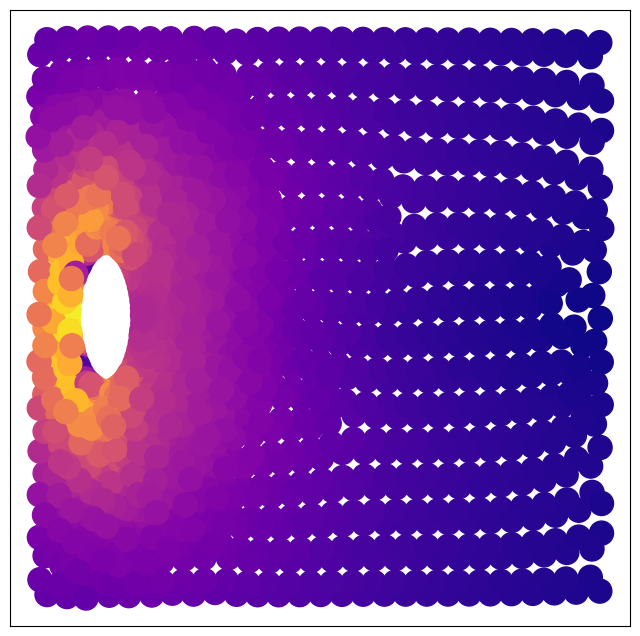

In [18]:
import networkx as nx

G = nx.Graph()

for i in range(len(position_data)):
    G.add_node(i, pos= position_data[i], mass = node_masses[i])
plt.figure(figsize=(8, 8))

node_pos = {i: tuple(node_positions[i]) for i in range(len(node_positions))}

nx.draw_networkx_nodes(G, node_pos,  node_color=node_states[0,:,-1], cmap=plt.cm.plasma, label=True)

In [7]:
position_data[0]

array([0.41894299, 0.30011299])

In [8]:
position_data[27]

array([0.44693401, 0.286908  ])

In [11]:
for i in range(edge_index.shape[-1]):
    print(edge_index[:,i])
    idx = edge_index[:,i]
    x, y = position_data[idx[0]]
    print(x)
    print(y)
    print(position_data[idx[0]])
    print(position_data[idx[-1]])
    break

[ 0 27]
0.41894298791885376
0.3001129925251007
[0.41894299 0.30011299]
[0.44693401 0.286908  ]


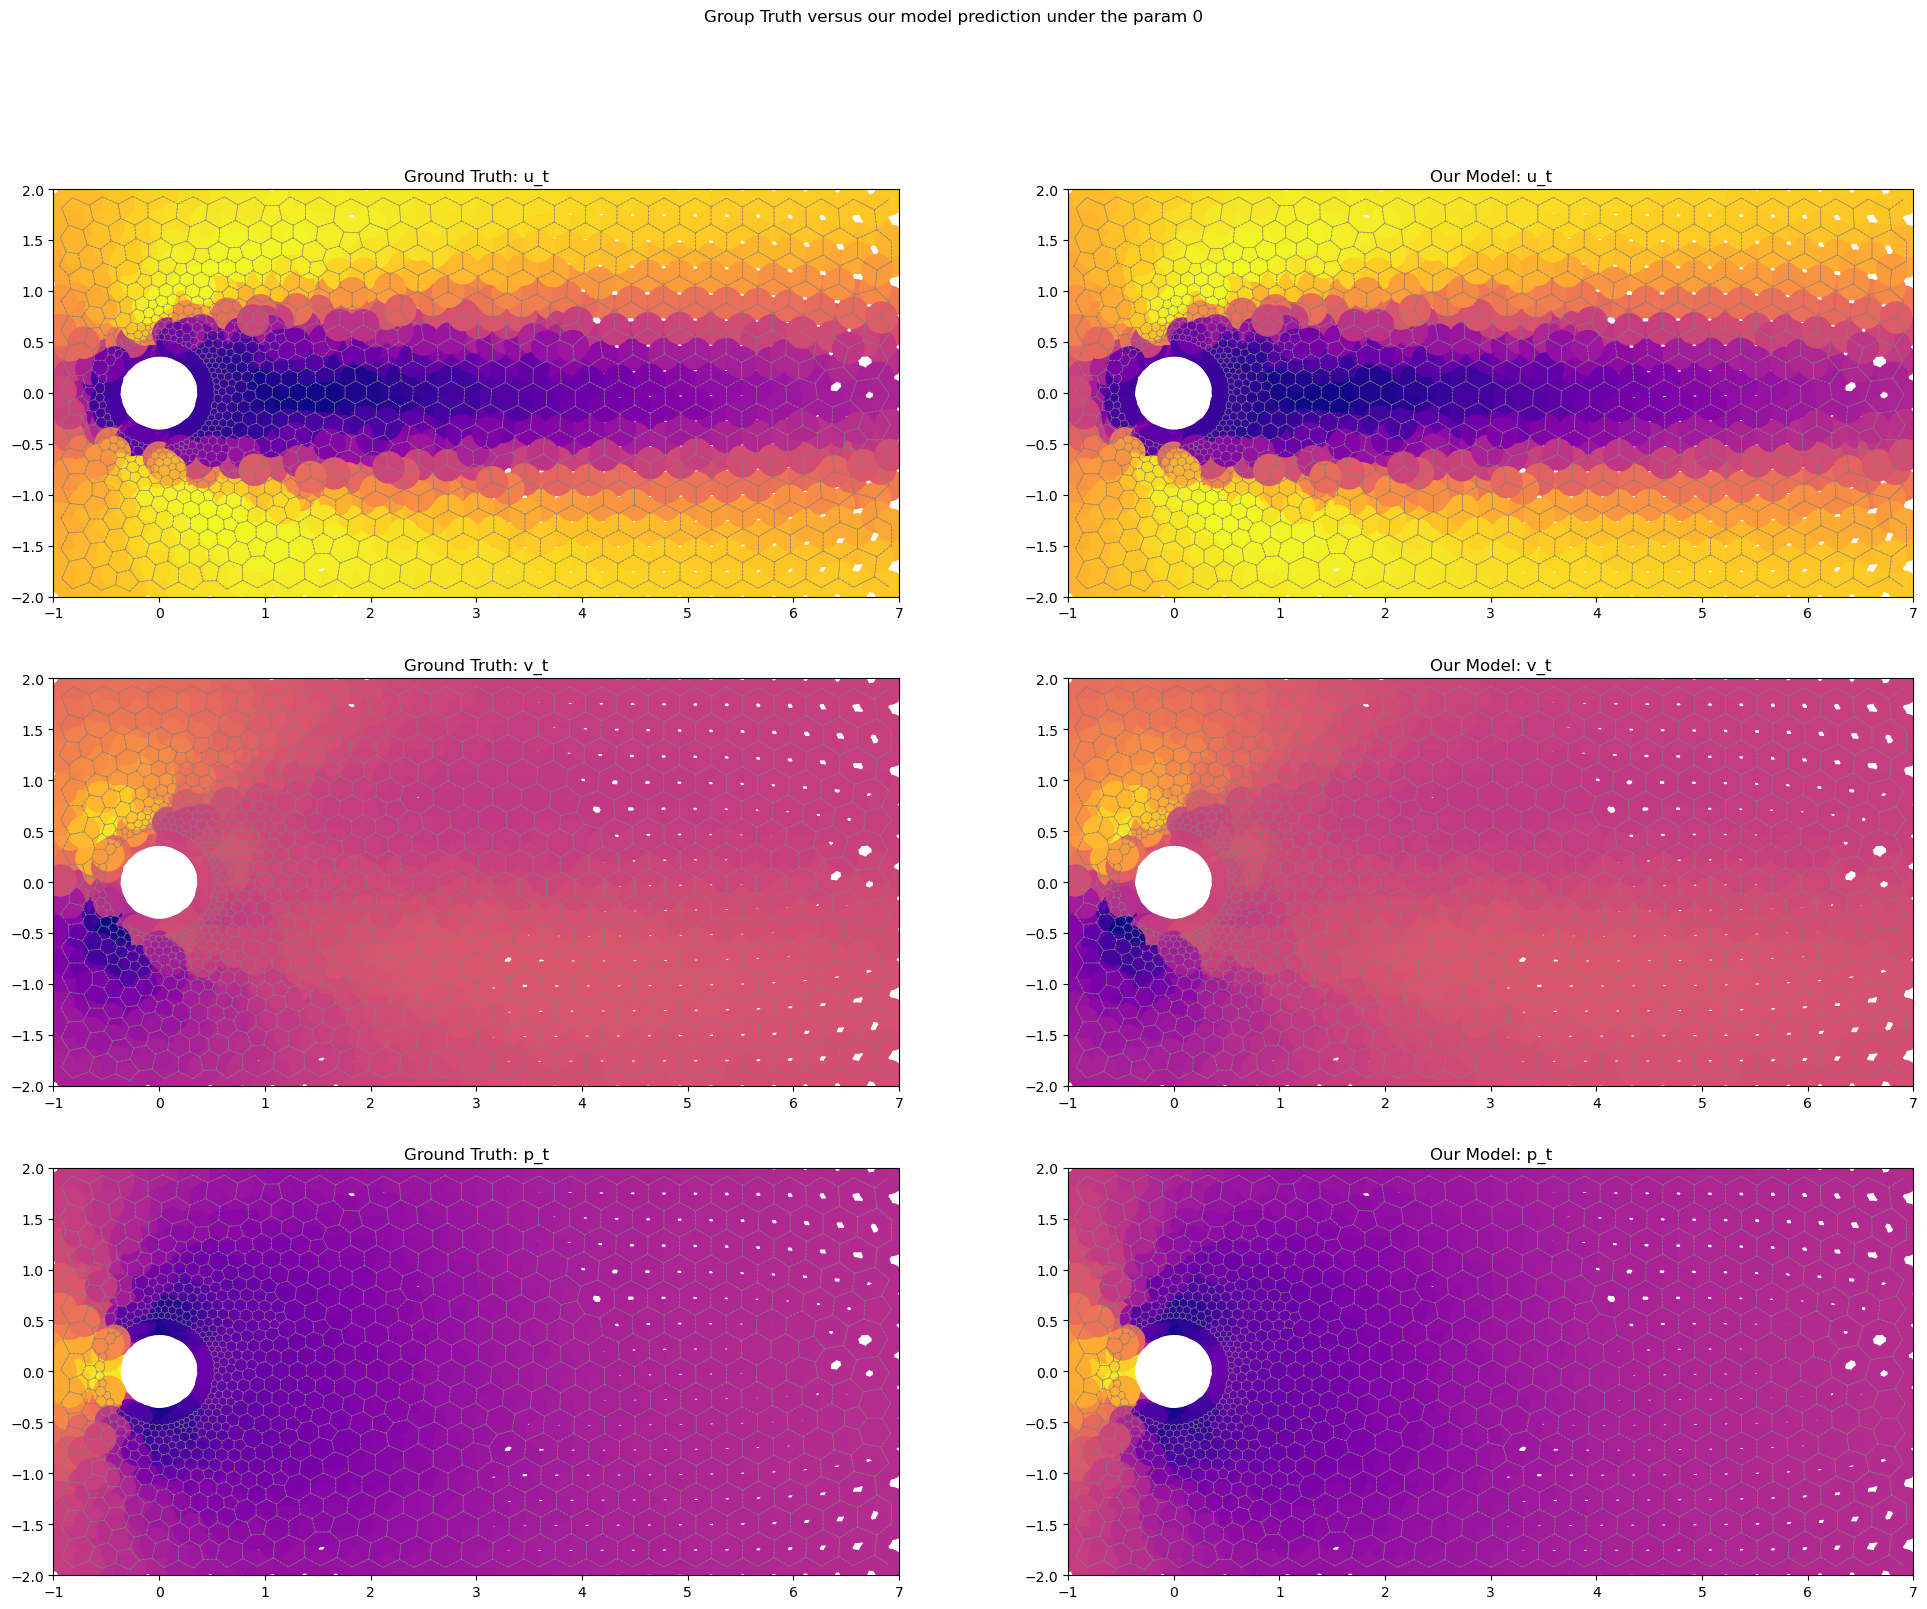

In [20]:
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(3,2, figsize=(24, 12))
fig, axes = plt.subplots(3,2, figsize=(24, 18))
titles = ['Ground Truth: u_t','Our Model: u_t','Ground Truth: v_t','Our Model: v_t','Ground Truth: p_t','Our Model: p_t']
fig.suptitle(f"Group Truth versus our model prediction under the Reynolds param {str(param_idx)}")
for i, ax in enumerate(axes.flat):
    ax.set_xlim(-1,7)
    ax.set_ylim(-2,2)
    ax.set_title(titles[i])
#node_pos = {i: tuple(position_data[i]) for i in range(len(position_data))}

scatters = []
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        scatter = ax.scatter(position_data[:, 0], position_data[:, 1], c=node_states[0, :, i//2], cmap=plt.cm.plasma, s=500)
    else:
        scatter = ax.scatter(position_data[:, 0], position_data[:, 1], c=node_states_mgn[0, :, i//2], cmap=plt.cm.plasma, s=500)
    
    for j in range(edge_index.shape[-1]):
        idx = edge_index[:,j]
        x_1, y_1 = position_data[idx[0]]
        x_2, y_2 = position_data[idx[1]]
        ax.plot(
            [x_1, x_2], [y_1, y_2], color='gray', linestyle='--', linewidth=0.5, alpha=0.8
        )
        
    scatters.append(scatter)


def update(frame):
    for i, scatter in enumerate(scatters):
        if i % 2 == 0:
            scatter.set_array(node_states[frame, :, i // 2])  # Update the data for each subplot
        else:
            scatter.set_array(node_states_mgn[frame, :, i // 2])
    return scatters

# Create the animation
ani = FuncAnimation(fig, update, frames=len(node_states), interval=100, blit=True)

# To save the animation as a GIF
#ani.save('node_state_time_series.gif', writer='Pillow', fps=30)

plt.show()

/tmp/ipykernel_2788213/4257339658.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=tick_fontsize, family='serif')  # Customize x-tick labels
/tmp/ipykernel_2788213/4257339658.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=tick_fontsize, family='serif')
/home/zhzhou/anaconda3/envs/eth_dl/lib/python3.10/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


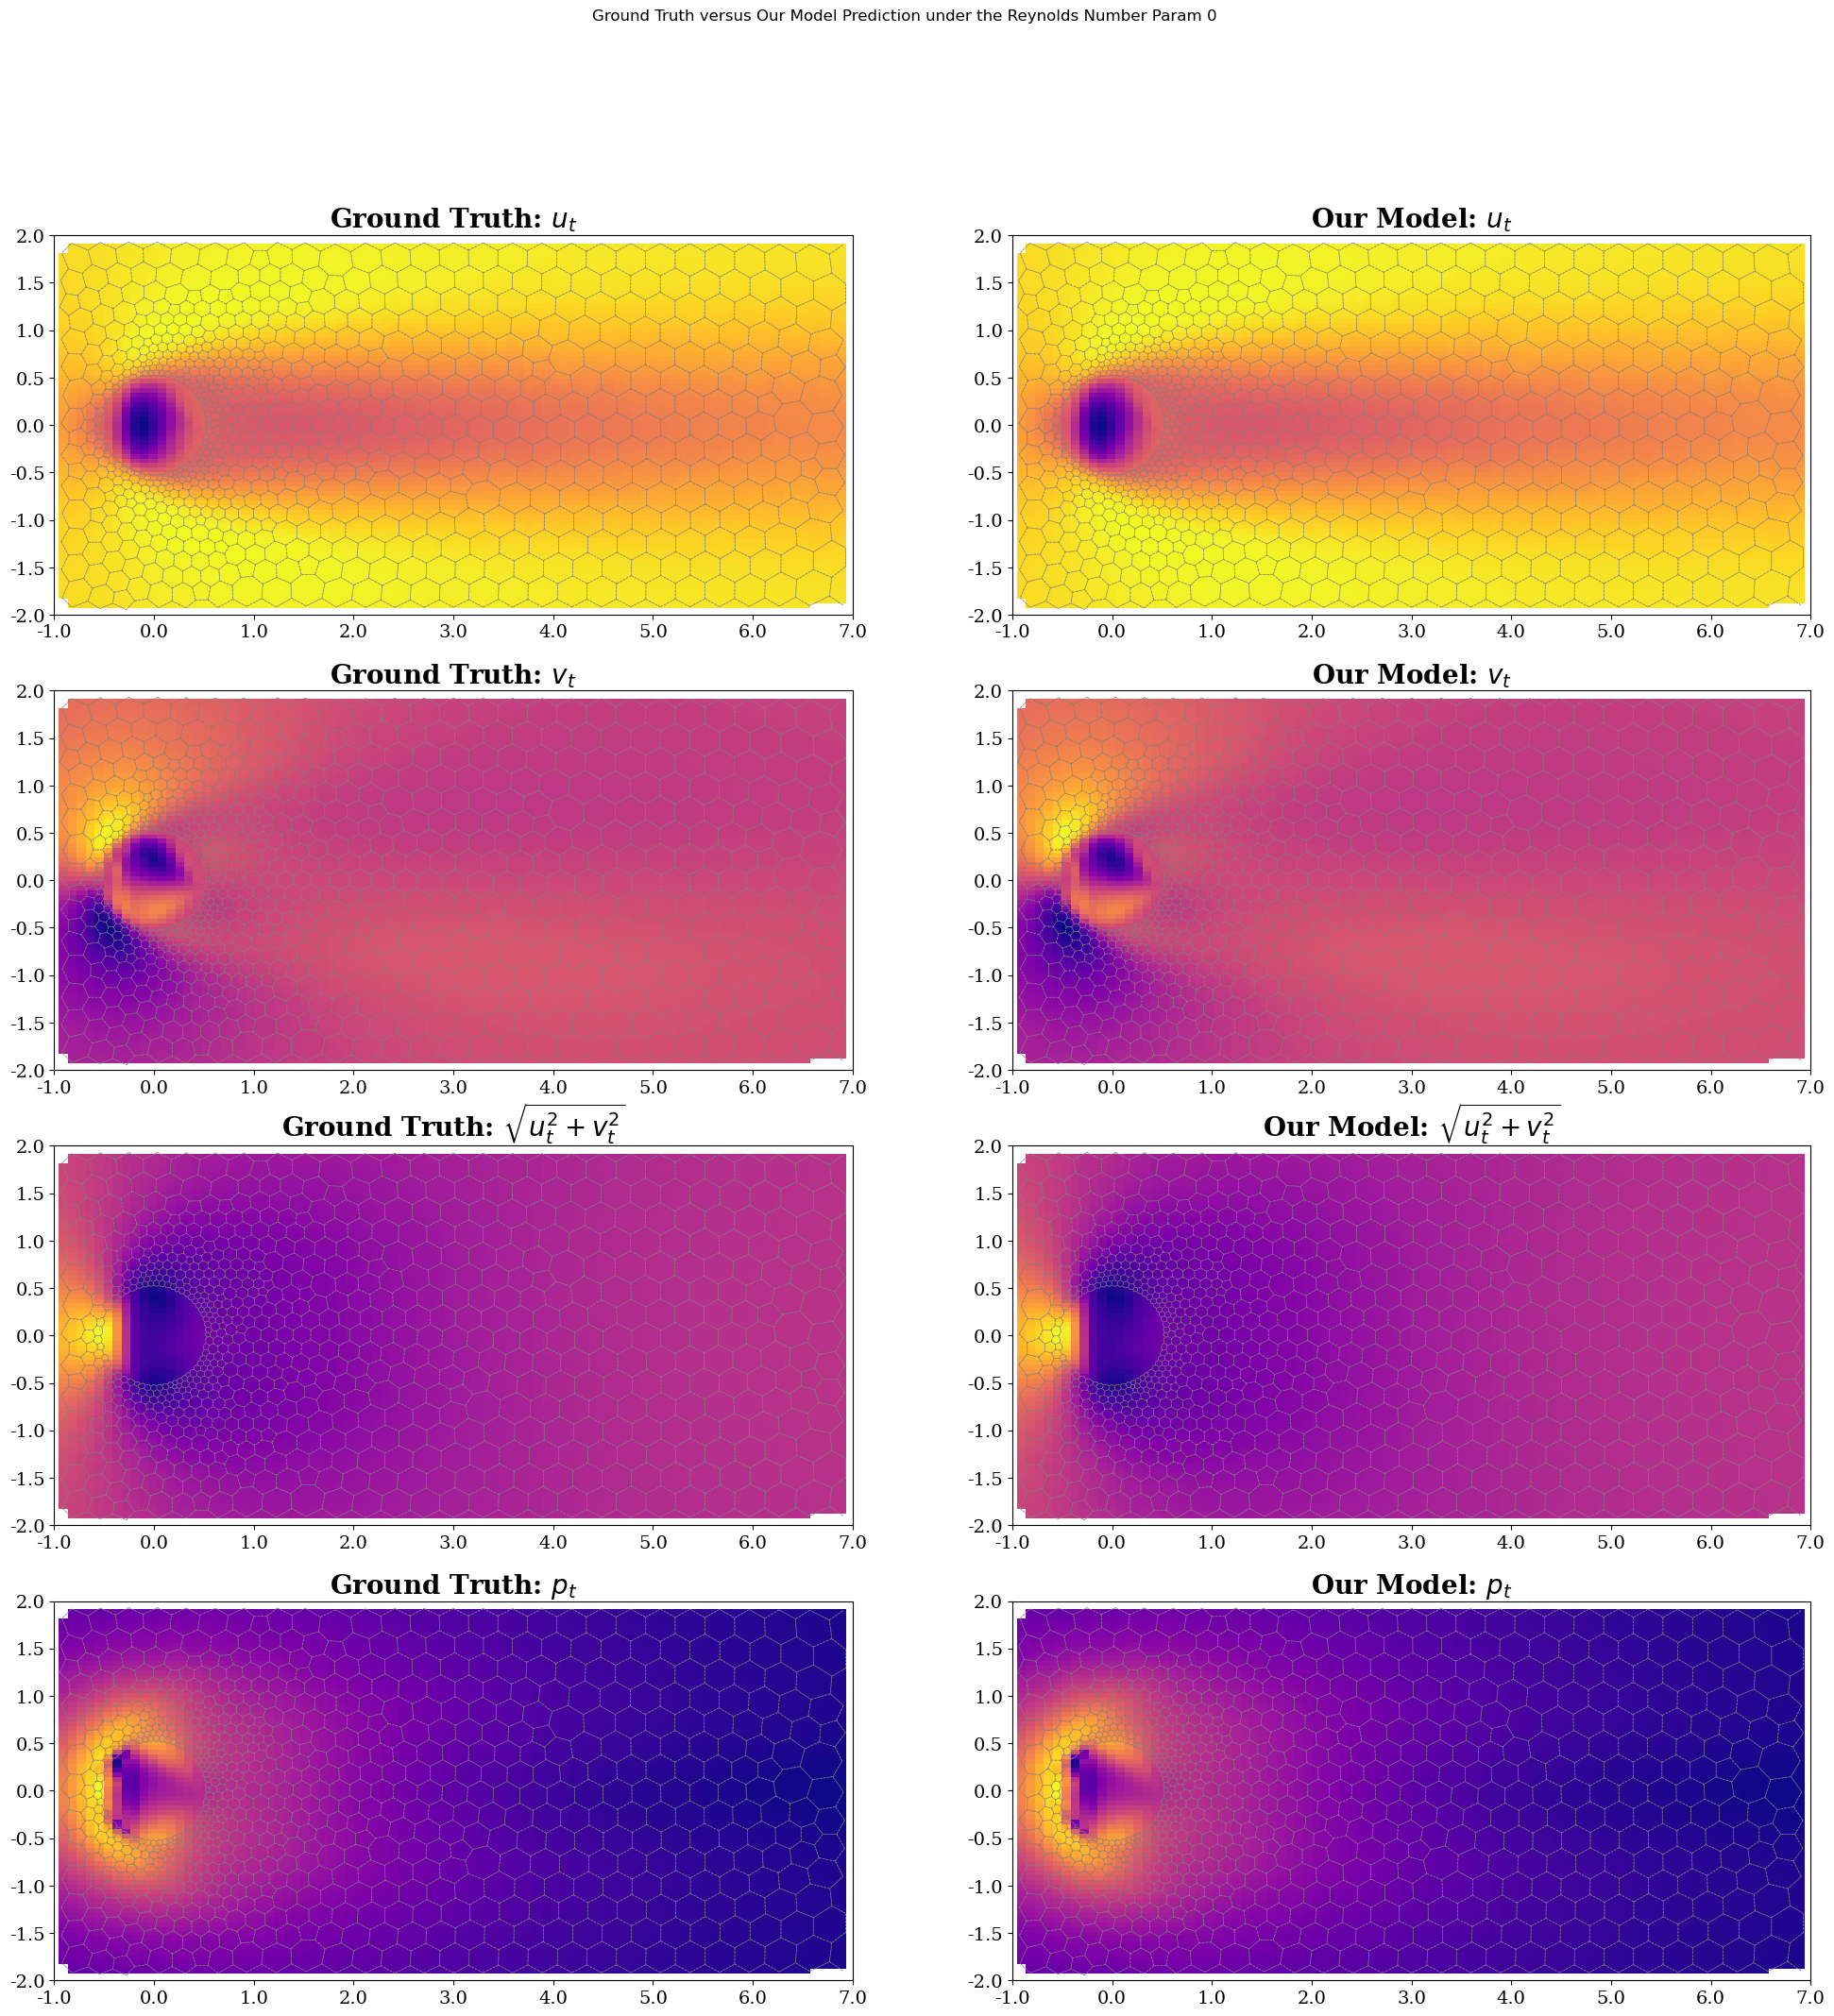

In [26]:
import argparse
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

def parse_args():
    parser = argparse.ArgumentParser(description="Smooth Mesh Animation")
    parser.add_argument('--param', type=int, help='Param idx')
    return parser.parse_args()

# Load ground truth testset data
param_idx_ls = [i for i in range(101) if i % 2 ==1]
param_idx = 0
data_path = '../data/rawData.npy'
raw_data = np.load(data_path, allow_pickle=True)
position_data = np.loadtxt('../data/meshPosition_all.txt')
node_states = raw_data['x'][param_idx_ls][param_idx]
node_states = add_total_velocity(node_states)
node_masses = raw_data['mass']
edge_attrs = raw_data['edge_attr']
edge_index = raw_data['edge_index']
node_positions = position_data.copy()

with open('../data/node_stats.json','r') as f:
    node_stats = json.load(f)
node_mean = node_stats['node_mean']
node_std = node_stats['node_std']

# test rollout result
result_path = '../data/rollout_result_vanilla_mgn.npy'
node_states_mgn = np.load(result_path, allow_pickle=True)*node_std + node_mean
node_states_mgn = np.concatenate((raw_data['x'][param_idx_ls][:,0,:,:][:,np.newaxis,:,:],node_states_mgn ), axis=1)[param_idx]
node_states_mgn = add_total_velocity(node_states_mgn)

fig, axes = plt.subplots(4, 2, figsize=(24, 24))
suptitle_font = {'fontsize': 24, 'fontweight': 'bold', 'family': 'serif'}

# Titles for the subplots
titles = [
    r'Ground Truth: $u_t$', r'Our Model: $u_t$',
    r'Ground Truth: $v_t$', r'Our Model: $v_t$',
    r'Ground Truth: $\sqrt{u_t^2 + v_t^2}$', r'Our Model: $\sqrt{u_t^2 + v_t^2}$',
    r'Ground Truth: $p_t$', r'Our Model: $p_t$'
]

# Define figure and axes
title_font = {'fontsize': 20, 'fontweight': 'bold', 'family': 'serif'}
tick_fontsize = 14
suptitle_font = {'fontsize': 24, 'fontweight': 'bold', 'family': 'serif'}

# Customize each subplot
for i, ax in enumerate(axes.flat):
    ax.set_xlim(-1, 7)
    ax.set_ylim(-2, 2)
    ax.set_title(titles[i], fontdict=title_font)  # Set custom font for titles

    # Customize tick parameters
    ax.tick_params(axis='both', labelsize=tick_fontsize)  # Adjust tick font size
    ax.set_xticklabels(ax.get_xticks(), fontsize=tick_fontsize, family='serif')  # Customize x-tick labels
    ax.set_yticklabels(ax.get_yticks(), fontsize=tick_fontsize, family='serif')

# Create grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(position_data[:, 0].min()-0.5, position_data[:, 0].max()+0.5, 100),
    np.linspace(position_data[:, 1].min()-0.5, position_data[:, 1].max()+0.5, 100)
)

# Function to plot the mesh
def plot_mesh(ax, data, title):
    interpolated = griddata(position_data, data, (grid_x, grid_y), method='cubic')
    mesh = ax.pcolormesh(grid_x, grid_y, interpolated, shading='auto', cmap=plt.cm.plasma)
    return mesh

# Initial meshes
meshes = []
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        mesh = plot_mesh(ax, node_states[0, :, i//2], titles[i])
    else:
        mesh = plot_mesh(ax, node_states_mgn[0, :, i//2], titles[i])
        
    for j in range(edge_index.shape[-1]):
        idx = edge_index[:,j]
        x_1, y_1 = position_data[idx[0]]
        x_2, y_2 = position_data[idx[1]]
        ax.plot(
            [x_1, x_2], [y_1, y_2], color='gray', linestyle='--', linewidth=0.5, alpha=0.8
        )
    meshes.append(mesh)

def update(frame):
    for i, mesh in enumerate(meshes):
        if i % 2 == 0:
            mesh.set_array(griddata(position_data, node_states[frame, :, i//2], (grid_x, grid_y), method='cubic').ravel())
        else:
            mesh.set_array(griddata(position_data, node_states_mgn[frame, :, i//2], (grid_x, grid_y), method='cubic').ravel())
    return meshes


# Create the animation
ani = FuncAnimation(fig, update, frames=len(node_states), interval=100, blit=True)

# To save the animation as a GIF
#ani.save('node_state_time_series_smooth.gif', writer='Pillow', fps=30)

plt.show()